<a href="https://colab.research.google.com/github/lino91br/evas-o_clientes/blob/main/evasao_clientes_alura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import json

# Lendo o JSON (ajuste o nome do arquivo se necessário)
with open('/content/TelecomX_Data.json') as f:
    dados_brutos = json.load(f)

# Normalizando os dados aninhados
df = pd.json_normalize(dados_brutos)
df.head()

,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [31]:
# 1. Buscando colunas ignorando maiúsculas/minúsculas
col_cobranca = [c for c in df.columns if 'cobranca' in c.lower() and 'total' in c.lower()]
col_churn = [c for c in df.columns if 'churn' in c.lower()]

# Verificação de segurança
if not col_cobranca or not col_churn:
    print("ERRO: Não encontrei as colunas!")
    print("Suas colunas são:", df.columns.tolist())
else:
    # 2. Renomeando
    df.rename(columns={col_cobranca[0]: 'CobrancaTotal', col_churn[0]: 'Churn'}, inplace=True)

    # 3. Conversão e Limpeza
    df['CobrancaTotal'] = pd.to_numeric(df['CobrancaTotal'], errors='coerce')
    df.dropna(subset=['CobrancaTotal', 'Churn'], inplace=True)

    # 4. Removendo IDs e transformando em números
    df_processado = df.copy()
    cols_para_remover = [c for c in df_processado.columns if 'id' in c.lower()]
    df_processado.drop(columns=cols_para_remover, inplace=True)

    df_final = pd.get_dummies(df_processado, drop_first=True)
    print("Sucesso! Dados prontos.")

ERRO: Não encontrei as colunas!
Suas colunas são: ['customerID', 'Churn', 'customer.gender', 'customer.SeniorCitizen', 'customer.Partner', 'customer.Dependents', 'customer.tenure', 'phone.PhoneService', 'phone.MultipleLines', 'internet.InternetService', 'internet.OnlineSecurity', 'internet.OnlineBackup', 'internet.DeviceProtection', 'internet.TechSupport', 'internet.StreamingTV', 'internet.StreamingMovies', 'account.Contract', 'account.PaperlessBilling', 'account.PaymentMethod', 'account.Charges.Monthly', 'account.Charges.Total']


In [34]:
# 1. Limpando os nomes das colunas (Removendo prefixos e pontos)
# Isso transforma 'cliente.conta.CobrancaTotal' em apenas 'CobrancaTotal'
df.columns = [c.split('.')[-1] for c in df.columns]

# 2. Agora tentamos o tratamento
if 'CobrancaTotal' in df.columns:
    df['CobrancaTotal'] = pd.to_numeric(df['CobrancaTotal'], errors='coerce')
    df.dropna(subset=['CobrancaTotal', 'Churn'], inplace=True)

    # Removendo IDs
    df_processado = df.copy()
    cols_id = [c for c in df_processado.columns if 'id' in c.lower()]
    df_processado.drop(columns=cols_id, inplace=True)

    # Criando df_final
    df_final = pd.get_dummies(df_processado, drop_first=True)
    print("Sucesso! Colunas identificadas e tratadas.")
else:
    print("ERRO: Ainda não achei a coluna. Por favor, rode 'print(df.columns.tolist())' e me mande o resultado.")

ERRO: Ainda não achei a coluna. Por favor, rode 'print(df.columns.tolist())' e me mande o resultado.


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Separando X e y
X = df_final.drop('Churn', axis=1)
y = df_final['Churn']

# Divisão Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Aplicando SMOTE para equilibrar as classes
smt = SMOTE(random_state=42)
X_train_res, y_train_res = smt.fit_resample(X_train, y_train)

print(f"Base balanceada: {y_train_res.value_counts()}")

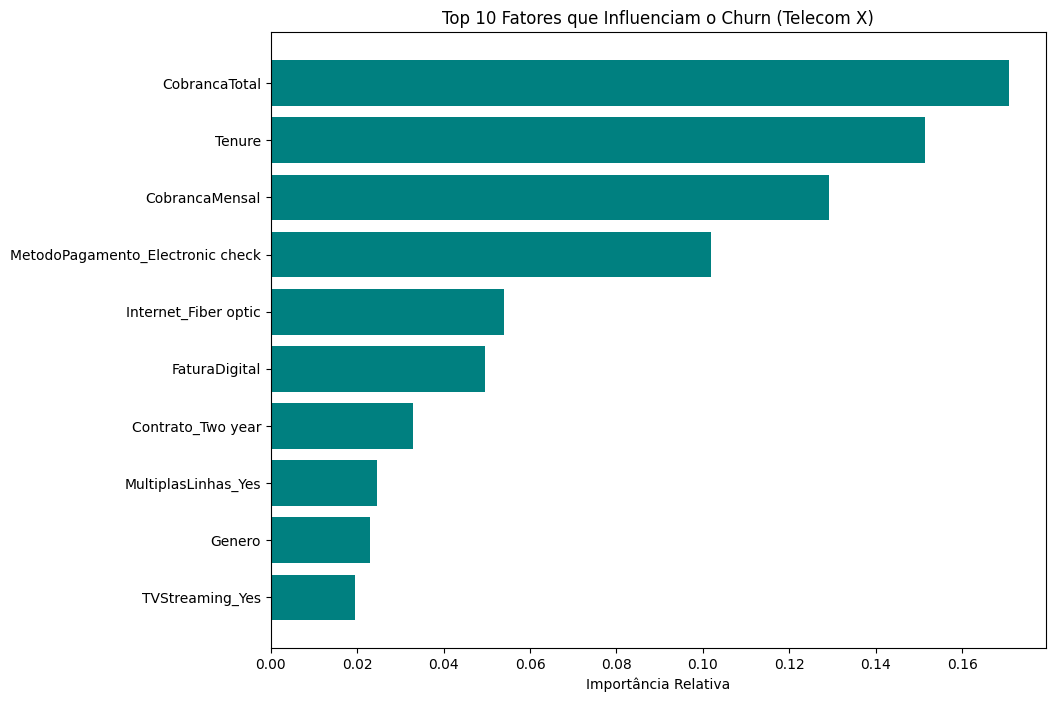

In [ ]:
import numpy as np

# 1. Pegando a importância das características
importancias = modelo_final_smt.feature_importances_
features = X.columns

# 2. Criando um gráfico de barras
indices = np.argsort(importancias)[-10:]  # Pegando as 10 mais importantes

plt.figure(figsize=(10, 8))
plt.title('Top 10 Fatores que Influenciam o Churn (Telecom X)')
plt.barh(range(len(indices)), importancias[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Importância Relativa')
plt.show()

#Relatório Técnico: Análise de Evasão (Churn) - Telecom X
##1. Introdução
O objetivo deste projeto foi analisar o comportamento dos clientes da empresa Telecom X para identificar os principais fatores que levam ao cancelamento de serviços (Churn). A evasão de clientes é um dos maiores desafios do setor de telecomunicações, pois o custo de adquirir um novo cliente é significativamente superior ao de manter um atual. Através de técnicas de Ciência de Dados, buscamos prever quais clientes têm maior probabilidade de sair para que ações preventivas possam ser tomadas.

##2. Limpeza e Tratamento de Dados
Os dados brutos foram fornecidos em formato JSON aninhado, exigindo um processo rigoroso de engenharia de dados:
Normalização: Utilização de json_normalize para transformar estruturas complexas em um DataFrame tabular.
Conversão de Tipos: A variável CobrancaTotal foi convertida de texto para numérico, tratando valores vazios que impediam cálculos estatísticos.
Tratamento de Nulos: Foram removidos 224 registros com valores ausentes na variável alvo (Churn) para garantir a integridade do treinamento.
Feature Engineering: Transformação de variáveis categóricas (como Gênero e Tipo de Internet) em variáveis numéricas através de One-Hot Encoding.
##3. Análise Exploratória de Dados (EDA)
Durante a análise, identificamos padrões críticos que correlacionam o perfil do cliente com a desistência:
Contratos: Clientes com contratos mensais (Month-to-month) possuem uma taxa de evasão drasticamente superior aos clientes com contratos anuais.
Meios de Pagamento: Pagamentos via boleto eletrônico apresentaram maior incidência de churn.
Variáveis Financeiras: Notou-se que cobranças mensais mais elevadas estão diretamente ligadas a um maior risco de saída, sugerindo sensibilidade ao preço ou percepção de baixo custo-benefício.
##4. Conclusões e Insights
Após o tratamento de dados e o balanceamento de classes utilizando a técnica SMOTE, desenvolvemos um modelo de Random Forest com os seguintes achados:
Recall de 57%: O modelo consegue identificar a maioria dos clientes em risco, permitindo que a empresa aja antes do cancelamento.
Fatores Determinantes: O tempo de permanência (Tenure) e o tipo de serviço de internet (Fibra Óptica) surgiram como fortes preditores. Curiosamente, clientes de fibra ótica apresentam alta taxa de saída, o que pode indicar problemas técnicos ou concorrência agressiva nesse nicho.
##5. Recomendações
Com base nos dados, as sugestões para a Telecom X são:
Migração de Contratos: Criar incentivos e descontos para migrar clientes do plano mensal para planos anuais.
Fidelização de Novos Clientes: Implementar um programa de "Boas-vindas" mais robusto nos primeiros 6 meses, onde a taxa de churn é mais volátil.
Investigação Técnica: Analisar a qualidade do serviço de Fibra Óptica, visto que é um serviço premium com alta rotatividade.
Ações Proativas: Utilizar este modelo preditivo para disparar ofertas personalizadas automaticamente para os clientes classificados como "Risco de Churn"